<!-- Autogenerated by `scripts/make_examples.py` -->
<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/voxel51/fiftyone-examples/blob/master/examples/pytorch_detection_training.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791629-6e618700-5769-11eb-857f-d176b37d2496.png" height="32" width="32">
            Try in Google Colab
        </a>
    </td>
    <td>
        <a target="_blank" href="https://nbviewer.jupyter.org/github/voxel51/fiftyone-examples/blob/master/examples/pytorch_detection_training.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791634-6efa1d80-5769-11eb-8a4c-71d6cb53ccf0.png" height="32" width="32">
            Share via nbviewer
        </a>
    </td>
    <td>
        <a target="_blank" href="https://github.com/voxel51/fiftyone-examples/blob/master/examples/pytorch_detection_training.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791633-6efa1d80-5769-11eb-8ee3-4b2123fe4b66.png" height="32" width="32">
            View on GitHub
        </a>
    </td>
    <td>
        <a href="https://github.com/voxel51/fiftyone-examples/raw/master/examples/pytorch_detection_training.ipynb" download>
            <img src="https://user-images.githubusercontent.com/25985824/104792428-60f9cc00-576c-11eb-95a4-5709d803023a.png" height="32" width="32">
            Download notebook
        </a>
    </td>
</table>


# PyTorch object detection model training

[PyTorch](https://pytorch.org/) datasets provide a great starting point for loading complex datasets, letting you define a class to load individual samples from disk and then creating data loaders to efficiently supply the data to your model. Problems arise when you want to start iterating over your dataset itself. PyTorch datasets are fairly rigid and require you to either rewrite them or the underlying data on disk if you want to make any changes to the data you are training or testing your model on. That is where [FiftyOne](http://fiftyone.ai) comes in.

PyTorch datasets can synergize well with [FiftyOne datasets](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#using-fiftyone-datasets) for hard computer vision problems like [classification, object detection, segmentation, and more](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#labels). 
The flexibility of FiftyOne datasets lets you easily experiment with and finetune the datasets you use for training and testing to create better-performing models, faster.
In this example, I am focusing on object detection since that is one of the most common vision tasks while also being fairly complex. However, these methods work for most machine learning tasks. Specifically, this notebook covers:
* Loading your labeled dataset into FiftyOne
* Writing a PyTorch object detection dataset that utilizes your loaded FiftyOne dataset
* Exploring views into your FiftyOne dataset for training and evaluation
* Training a Torchvision object detection model on your FiftyOne dataset views
* Evaluating your models in FiftyOne to refine your dataset

## Setup

**Before you begin!** If you are running this in Colab, make sure you select a GPU instance under `Runtime` > `Change runtime type` since this notebook contains some model training.

To start, we need to install fiftyone, pytorch, and torchvision, as well as clone the torchvision GitHub repository to use the training and evaluation utilities provided for the [Torchvision Object Deteciton Tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#defining-the-dataset) that we are using to train a basic object detection model.

``` shell
pip install fiftyone
pip install torch torchvision
```

If you run into a `cv2` error when importing FiftyOne later on, it is an issue with OpenCV in Colab environments. [Follow these instructions to resolve it.](https://github.com/voxel51/fiftyone/issues/1494#issuecomment-1003148448)

```shell
# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0
cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../
```


## Loading your data

Getting your data into FiftyOne is oftentimes actually easier than getting it into a PyTorch dataset. Additionally, once the data is in FiftyOne it is much more flexible allowing you to easily find and access even the most specific subsets of data that you can then use to train or evaluate your model.

If you have data that follows a certain format on disk ([for example a directory tree for classification, the COCO detection format, or many more](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html#id1)), then you can load it into FiftyOne in [one line of code](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html).

In this notebook, I am going to work with [COCO-2017](https://cocodataset.org/#home) and load it from the [FiftyOne Dataset Zoo](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/index.html).

In [1]:
import torch

torch.manual_seed(1)

In [2]:
import fiftyone as fo
import fiftyone.zoo as foz

In [3]:
fo_dataset = foz.load_zoo_dataset(name="coco-2017", split="validation",dataset_dir="fiftyone/coco")

Found annotations at 'fiftyone/coco/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'validation'
 100% |███████████████| 5000/5000 [24.5s elapsed, 0s remaining, 193.9 samples/s]      
Dataset 'coco-2017-validation' created


We will be needing the height and width of images later in this notebook so we need to compute metadata on our dataset.

In [4]:
fo_dataset.compute_metadata()

We can create a session and visualize this dataset in the [FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html).


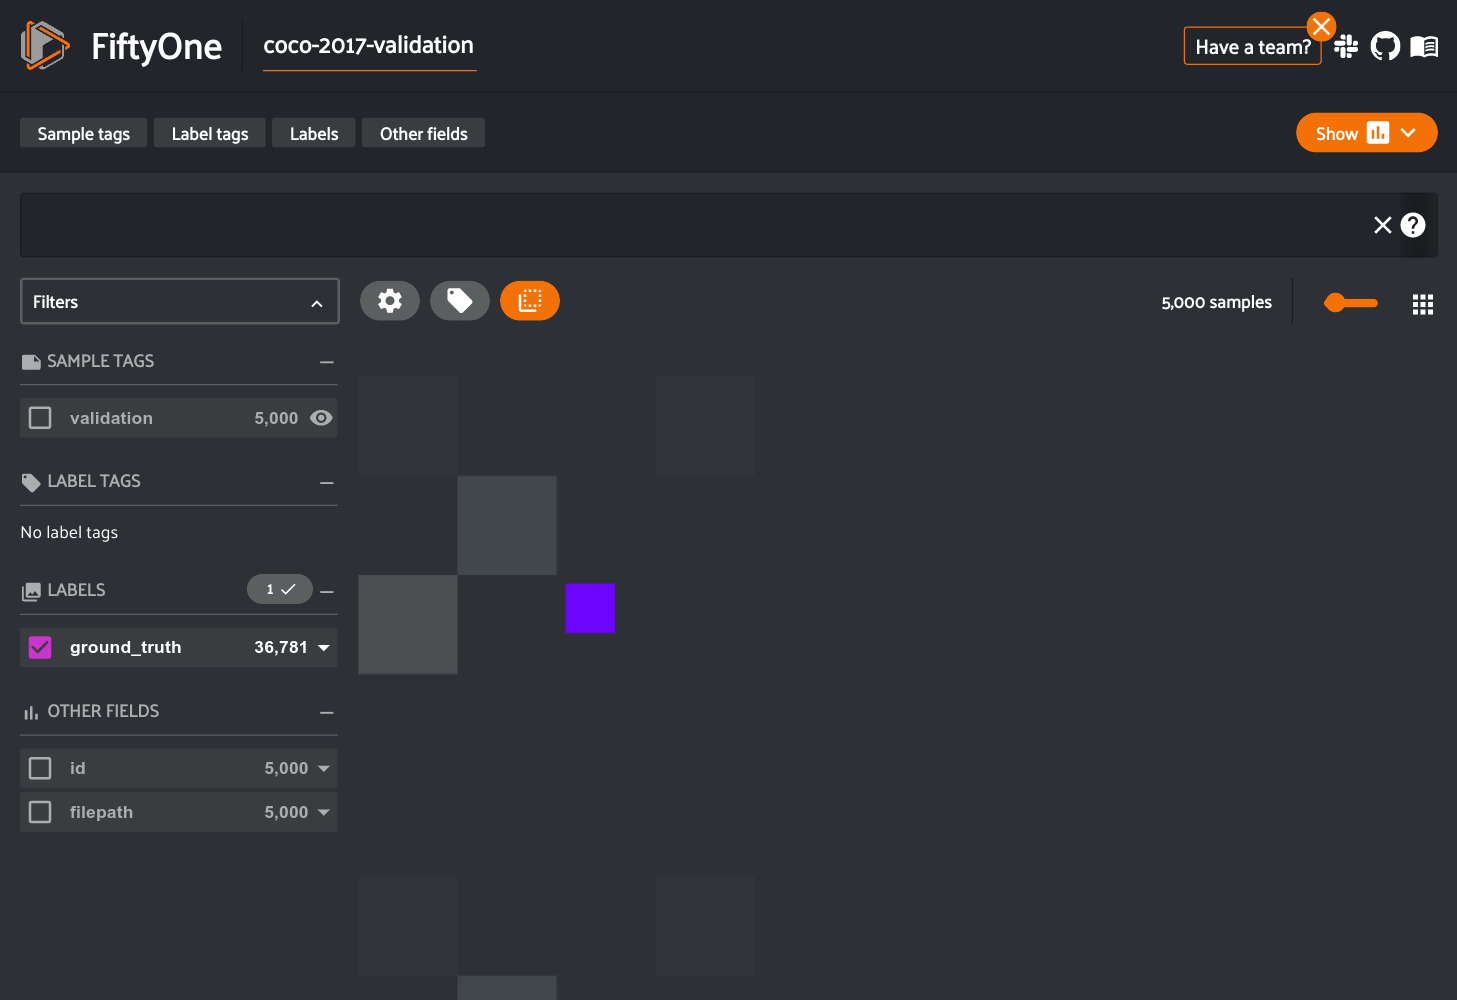

In [5]:
session = fo.launch_app(fo_dataset)

## PyTorch dataset and training setup

A [PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class) is a class that defines how to load a static dataset and its labels from disk via a simple iterator interface. They differ from FiftyOne datasets which are flexible representations of your data geared towards visualization, querying, and understanding.

Every PyTorch model expects data and labels to pass into it in a certain format. Before being able to write up a PyTorch dataset class, you first need to understand the format that the model requires. Namely, we need to know exactly what format the data loader is expected to output when iterating through the dataset so that we can properly define the `__getitem__` method in the PyTorch dataset.
In this example, I am following the [Torchvision object detection tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#defining-the-dataset) and construct a PyTorch dataset to work with their RCNN-based models.

In [6]:
import torch
import fiftyone.utils.coco as fouc
from PIL import Image


class FiftyOneTorchDataset(torch.utils.data.Dataset):
    """A class to construct a PyTorch dataset from a FiftyOne dataset.
    
    Args:
        fiftyone_dataset: a FiftyOne dataset or view that will be used for training or testing
        transforms (None): a list of PyTorch transforms to apply to images and targets when loading
        gt_field ("ground_truth"): the name of the field in fiftyone_dataset that contains the 
            desired labels to load
        classes (None): a list of class strings that are used to define the mapping between
            class names and indices. If None, it will use all classes present in the given fiftyone_dataset.
    """

    def __init__(
        self,
        fiftyone_dataset,
        transforms=None,
        gt_field="ground_truth",
        classes=None,
    ):
        self.samples = fiftyone_dataset
        self.transforms = transforms
        self.gt_field = gt_field

        self.img_paths = self.samples.values("filepath")

        self.classes = classes
        if not self.classes:
            # Get list of distinct labels that exist in the view
            self.classes = self.samples.distinct(
                "%s.detections.label" % gt_field
            )

        if self.classes[0] != "background":
            self.classes = ["background"] + self.classes

        self.labels_map_rev = {c: i for i, c in enumerate(self.classes)}

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        sample = self.samples[img_path]
        metadata = sample.metadata
        img = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        area = []
        iscrowd = []
        detections = sample[self.gt_field].detections
        for det in detections:
            category_id = self.labels_map_rev[det.label]
            coco_obj = fouc.COCOObject.from_label(
                det, metadata, category_id=category_id,
            )
            x, y, w, h = coco_obj.bbox
            boxes.append([x, y, x + w, y + h])
            labels.append(coco_obj.category_id)
            area.append(coco_obj.area)
            iscrowd.append(coco_obj.iscrowd)

        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        target["image_id"] = torch.as_tensor([idx])
        target["area"] = torch.as_tensor(area, dtype=torch.float32)
        target["iscrowd"] = torch.as_tensor(iscrowd, dtype=torch.int64)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.img_paths)

    def get_classes(self):
        return self.classes

The following code loads Faster-RCNN with a ResNet50 backbone from Torchvision and modifies the classifier for the number of classes we are training on:

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

For this example, we are going to write a simple training loop. This function is going to take a model and our PyTorch datasets as input and use the [`train_one_epoch()`](https://github.com/pytorch/vision/blob/master/references/detection/engine.py) and [`evaluate()`](https://github.com/pytorch/vision/blob/master/references/detection/engine.py) functions from the Torchvision object detection code

In [8]:
# Import functions from the torchvision references we cloned
from engine import train_one_epoch, evaluate
import utils

def do_training(model, torch_dataset, torch_dataset_test, num_epochs=4):
    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        torch_dataset, batch_size=2, shuffle=True, num_workers=2,
        collate_fn=utils.collate_fn)
    
    data_loader_test = torch.utils.data.DataLoader(
        torch_dataset_test, batch_size=1, shuffle=False, num_workers=2,
        collate_fn=utils.collate_fn)

    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print("Using device %s" % device)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=3,
                                                    gamma=0.1)

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

## FiftyOne views and datasets

One of the primary ways of interacting with your FiftyOne dataset is through different [views](https://voxel51.com/docs/fiftyone/user_guide/using_views.html) into your dataset. These are constructed by applying operations like filtering, sorting, slicing, etc, that result in a specific view into certain labels/samples of your dataset. These operations make it easier to experiment with different subsets of data and continue to finetune your dataset to train better models.



For example, cluttered images make it difficult for models to localize objects. We can use FiftyOne to create a view containing only samples with more than, say, 10 objects. You can perform the same operations on views as datasets, so we can create an instance of our PyTorch dataset from this view:

In [9]:
from fiftyone import ViewField as F

busy_view = fo_dataset.match(F("ground_truth.detections").length() > 10)

busy_torch_dataset = FiftyOneTorchDataset(busy_view)

In [10]:
session.view = busy_view

Another example is if we want to train a model that is used primarily for road vehicle detection. We can easily create training and testing views (and corresponding PyTorch datasets) that only contain the classes car, truck, and bus:

In [11]:
from fiftyone import ViewField as F

vehicles_list = ["car", "truck", "bus"]
vehicles_view = fo_dataset.filter_labels("ground_truth",
        F("label").is_in(vehicles_list))

print(len(vehicles_view))

707


In [12]:
session.view = vehicles_view

In [13]:
# From the torchvision references we cloned
import transforms as T

train_transforms = T.Compose([T.ToTensor(), T.RandomHorizontalFlip(0.5)])
test_transforms = T.Compose([T.ToTensor()])

In [14]:
# split the dataset in train and test set
train_view = vehicles_view.take(500, seed=51)
test_view = vehicles_view.exclude([s.id for s in train_view])

In [15]:
# use our dataset and defined transformations
torch_dataset = FiftyOneTorchDataset(train_view, train_transforms,
        classes=vehicles_list)
torch_dataset_test = FiftyOneTorchDataset(test_view, test_transforms, 
        classes=vehicles_list)

## Training and Evaluation

In this section, we use the functions and datasets we defined above to initialize, train, and evaluate a model continuing with the vehicle example. 

In [16]:
model = get_model(len(vehicles_list)+1)

In [17]:
do_training(model, torch_dataset, torch_dataset_test, num_epochs=4)

Using device cuda


/home/andrew/miniconda3/envs/pytorch/lib/python3.9/site-packages/pymongo/topology.py:164: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  warnings.warn(
/home/andrew/miniconda3/envs/pytorch/lib/python3.9/site-packages/pymongo/topology.py:164: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  warnings.warn(


RuntimeError: CUDA out of memory. Tried to allocate 206.00 MiB (GPU 0; 3.95 GiB total capacity; 3.07 GiB already allocated; 130.25 MiB free; 3.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

One of the main draws of FiftyOne is the ability to find failure modes of your model. The [built-in evaluation protocols](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html#evaluating-models) will help you find where your model got things right and where it got things wrong. Before we can evaluate the model, we need to run it on our test set and store the results in FiftyOne. Doing this is fairly simple and just requires us to run inference for the test images, get their corresponding [FiftyOne samples](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#samples), and add a new field called `predictions` to each sample to store the detections.

In [ ]:
import fiftyone as fo

def convert_torch_predictions(preds, det_id, s_id, w, h, classes):
    # Convert the outputs of the torch model into a FiftyOne Detections object
    dets = []
    for bbox, label, score in zip(
        preds["boxes"].cpu().detach().numpy(), 
        preds["labels"].cpu().detach().numpy(), 
        preds["scores"].cpu().detach().numpy()
    ):
        # Parse prediction into FiftyOne Detection object
        x0,y0,x1,y1 = bbox
        coco_obj = fouc.COCOObject(det_id, s_id, int(label), [x0, y0, x1-x0, y1-y0])
        det = coco_obj.to_detection((w,h), classes)
        det["confidence"] = float(score)
        dets.append(det)
        det_id += 1
        
    detections = fo.Detections(detections=dets)
        
    return detections, det_id

def add_detections(model, torch_dataset, view, field_name="predictions"):
    # Run inference on a dataset and add results to FiftyOne
    torch.set_num_threads(1)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print("Using device %s" % device)

    model.eval()
    model.to(device)
    image_paths = torch_dataset.img_paths
    classes = torch_dataset.classes
    det_id = 0
    
    with fo.ProgressBar() as pb:
        for img, targets in pb(torch_dataset):
            # Get FiftyOne sample indexed by unique image filepath
            img_id = int(targets["image_id"][0])
            img_path = image_paths[img_id]
            sample = view[img_path]
            s_id = sample.id
            w = sample.metadata["width"]
            h = sample.metadata["height"]
            
            # Inference
            preds = model(img.unsqueeze(0).to(device))[0]
            
            detections, det_id = convert_torch_predictions(
                preds, 
                det_id, 
                s_id, 
                w, 
                h, 
                classes,
            )
            
            sample[field_name] = detections
            sample.save()

In [ ]:
add_detections(model, torch_dataset_test, fo_dataset, field_name="predictions")

Using device cuda
 100% |█████████████████| 207/207 [31.5s elapsed, 0s remaining, 6.5 samples/s]      


In [ ]:
results = fo.evaluate_detections(
    test_view, 
    "predictions", 
    classes=["car", "bus", "truck"], 
    eval_key="eval", 
    compute_mAP=True
)

Evaluating detections...
 100% |█████████████████| 207/207 [5.5s elapsed, 0s remaining, 36.5 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 207/207 [8.1s elapsed, 0s remaining, 22.2 samples/s]       


The [DetectionResults](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.eval.detection.html#fiftyone.utils.eval.detection.DetectionResults) object that is returned stores information like the mAP and contains functions that let you [plot confusion matrices, precision-recall curves, and more](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html). Also, these evaluation runs are tracked in FiftyOne and can be managed through functions like [list_evaluations()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.list_evaluations).

In [ ]:
results.mAP()

0.3598547617444416

In [ ]:
results.print_report()

              precision    recall  f1-score   support

         car       0.20      0.87      0.32       610
         bus       0.13      0.88      0.23        68
       truck       0.10      0.88      0.18       112

   micro avg       0.17      0.87      0.28       790
   macro avg       0.14      0.88      0.24       790
weighted avg       0.18      0.87      0.29       790



By default, objects are only matched with other objects of the same class. In order to get an interesting confusion matrix, we need to match interclass objects by setting `classwise=False`.

In [ ]:
results_interclass = fo.evaluate_detections(
    test_view, 
    "predictions", 
    classes=["car", "bus", "truck"], 
    compute_mAP=True, 
    classwise=False
)

Evaluating detections...
 100% |█████████████████| 207/207 [6.3s elapsed, 0s remaining, 30.2 samples/s]       
Performing IoU sweep...
 100% |█████████████████| 207/207 [9.7s elapsed, 0s remaining, 16.9 samples/s]       


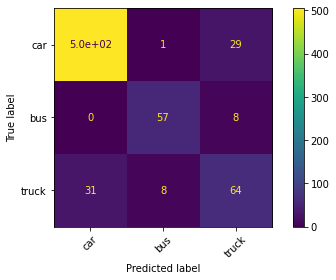

In [ ]:
results_interclass.plot_confusion_matrix()

Note that there appears to be confusion between car and truck classes.

The [detection evaluation](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html#detections) also added the attributes `eval_fp`, `eval_tp`, and `eval_fn` to every predicted detection indicating if it is a false positive, true positive, or false negative. 
Let's create a view to find the worst samples by sorting by `eval_fp` using the [FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html) to visualize the results. 


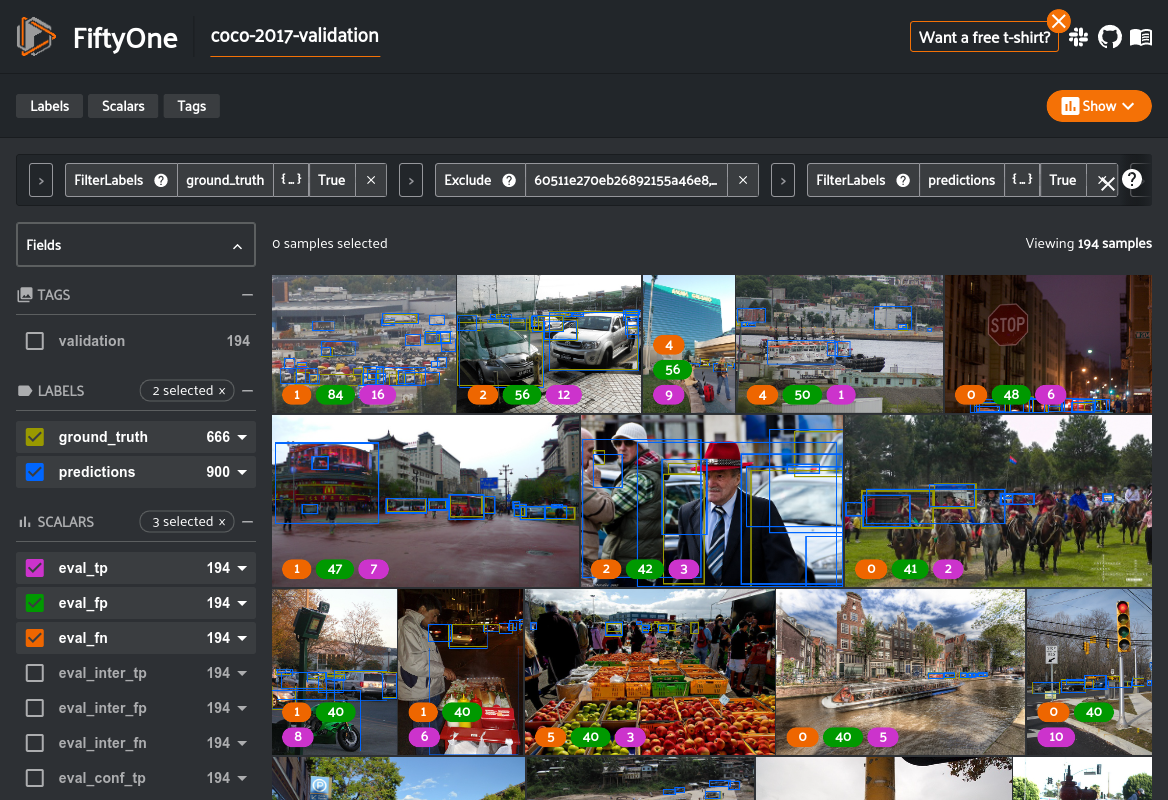

In [ ]:
session.view = test_view.sort_by("eval_fp", reverse=True)

Looking through some of these samples, we can see the confusion between the classes "car" and "truck" that we found earlier. However, this seems to be, at least in part, due to annotation errors on vans and SUVs where they are interchangably labeled as "car" and "truck". The example below shows an SUV annotated as "truck" but predicted as "car".


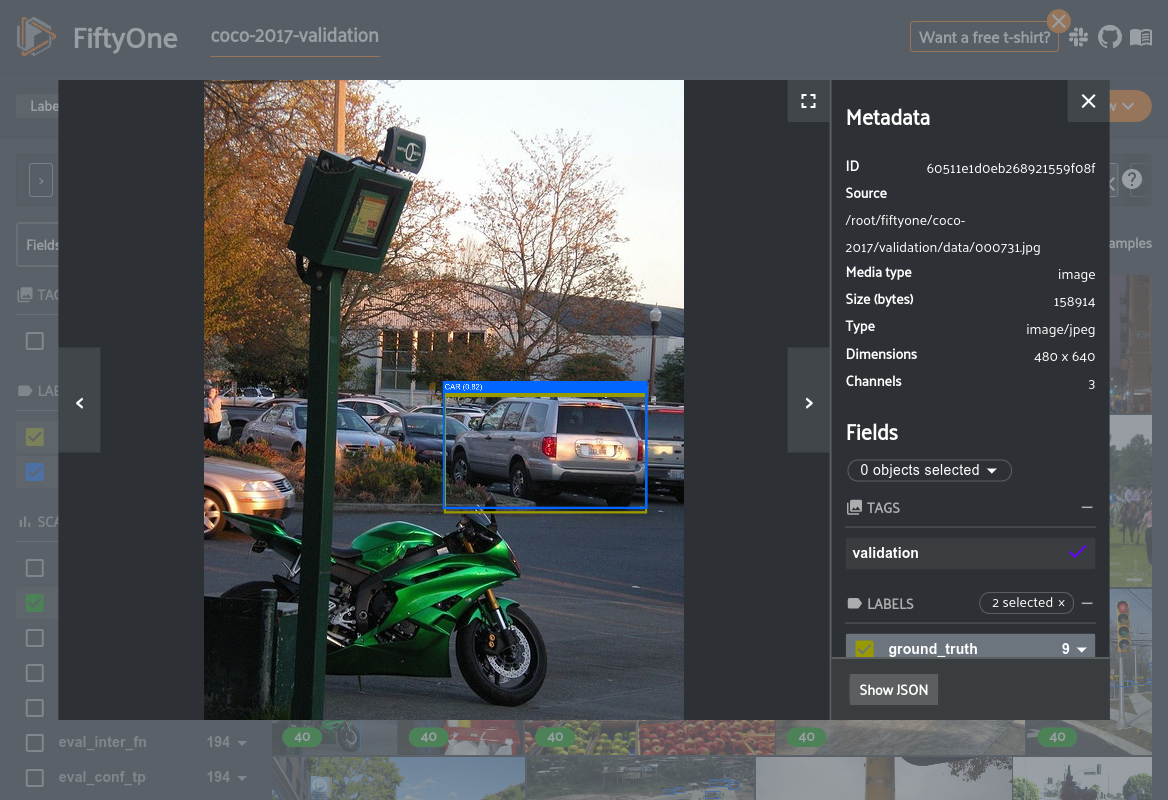

In [ ]:
session.view = test_view.sort_by("eval_fp", reverse=True)

It would be best to get this [data reannotated to fix these mistakes](https://towardsdatascience.com/managing-annotation-mistakes-with-fiftyone-and-labelbox-fc6e87b51102), but in the meantime, we can easily remedy this by simply creating a new view that remaps the labels `car`, `truck`, and `bus` all to `vehicle` and then retraining the model with that. This is only possible because we are backing our data in FiftyOne and loading views into PyTorch as needed. Without FiftyOne, the PyTorch dataset class or the underlying data would need to be changed to remap these classes.

In [ ]:
# map labels to single vehicle class 
vehicles_map = {c: "vehicle" for c in vehicles_list}

train_map_view = train_view.map_labels("ground_truth", vehicles_map)
test_map_view = test_view.map_labels("ground_truth", vehicles_map)

# use our dataset and defined transformations
torch_map_dataset = FiftyOneTorchDataset(train_map_view, train_transforms)
torch_map_dataset_test = FiftyOneTorchDataset(test_map_view, test_transforms)

In [ ]:
# Only 2 classes (background and vehicle)
vehicle_model = get_model(2)

In [ ]:
do_training(vehicle_model, torch_map_dataset, torch_map_dataset_test)

Using device cuda


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [0]  [  0/250]  eta: 0:04:47  lr: 0.000025  loss: 1.5123 (1.5123)  loss_classifier: 0.9323 (0.9323)  loss_box_reg: 0.5551 (0.5551)  loss_objectness: 0.0071 (0.0071)  loss_rpn_box_reg: 0.0178 (0.0178)  time: 1.1514  data: 0.2843  max mem: 4401
Epoch: [0]  [ 10/250]  eta: 0:02:35  lr: 0.000226  loss: 1.1389 (1.1536)  loss_classifier: 0.8300 (0.7482)  loss_box_reg: 0.3211 (0.3252)  loss_objectness: 0.0288 (0.0414)  loss_rpn_box_reg: 0.0125 (0.0387)  time: 0.6473  data: 0.0319  max mem: 4401
Epoch: [0]  [ 20/250]  eta: 0:02:28  lr: 0.000426  loss: 1.0465 (1.0374)  loss_classifier: 0.5113 (0.5782)  loss_box_reg: 0.3211 (0.3764)  loss_objectness: 0.0261 (0.0420)  loss_rpn_box_reg: 0.0125 (0.0407)  time: 0.6196  data: 0.0066  max mem: 4401
Epoch: [0]  [ 30/250]  eta: 0:02:24  lr: 0.000627  loss: 0.7177 (0.9652)  loss_classifier: 0.3202 (0.5004)  loss_box_reg: 0.4171 (0.3951)  loss_objectness: 0.0187 (0.0346)  loss_rpn_box_reg: 0.0168 (0.0350)  time: 0.6625  data: 0.0066  max mem: 4401


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Test:  [  0/207]  eta: 0:01:10  model_time: 0.1596 (0.1596)  evaluator_time: 0.0073 (0.0073)  time: 0.3383  data: 0.1694  max mem: 4722
Test:  [100/207]  eta: 0:00:13  model_time: 0.1203 (0.1171)  evaluator_time: 0.0024 (0.0046)  time: 0.1296  data: 0.0037  max mem: 4722
Test:  [200/207]  eta: 0:00:00  model_time: 0.1130 (0.1172)  evaluator_time: 0.0025 (0.0047)  time: 0.1215  data: 0.0033  max mem: 4722
Test:  [206/207]  eta: 0:00:00  model_time: 0.1128 (0.1171)  evaluator_time: 0.0034 (0.0049)  time: 0.1248  data: 0.0033  max mem: 4722
Test: Total time: 0:00:26 (0.1281 s / it)
Averaged stats: model_time: 0.1128 (0.1171)  evaluator_time: 0.0034 (0.0049)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.262
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.507
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.245
 Average Precision  (AP) @[ I

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [1]  [  0/250]  eta: 0:03:48  lr: 0.005000  loss: 0.2260 (0.2260)  loss_classifier: 0.0742 (0.0742)  loss_box_reg: 0.1216 (0.1216)  loss_objectness: 0.0229 (0.0229)  loss_rpn_box_reg: 0.0073 (0.0073)  time: 0.9124  data: 0.3390  max mem: 4722
Epoch: [1]  [ 10/250]  eta: 0:02:36  lr: 0.005000  loss: 0.4380 (0.4907)  loss_classifier: 0.1351 (0.1584)  loss_box_reg: 0.1715 (0.2241)  loss_objectness: 0.0317 (0.0482)  loss_rpn_box_reg: 0.0167 (0.0600)  time: 0.6532  data: 0.0360  max mem: 4722
Epoch: [1]  [ 20/250]  eta: 0:02:29  lr: 0.005000  loss: 0.3960 (0.4844)  loss_classifier: 0.1281 (0.1492)  loss_box_reg: 0.1715 (0.2056)  loss_objectness: 0.0358 (0.0673)  loss_rpn_box_reg: 0.0177 (0.0623)  time: 0.6360  data: 0.0061  max mem: 4722
Epoch: [1]  [ 30/250]  eta: 0:02:17  lr: 0.005000  loss: 0.3671 (0.4388)  loss_classifier: 0.1112 (0.1335)  loss_box_reg: 0.1653 (0.1906)  loss_objectness: 0.0371 (0.0578)  loss_rpn_box_reg: 0.0173 (0.0570)  time: 0.6098  data: 0.0066  max mem: 4722


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Test:  [  0/207]  eta: 0:01:11  model_time: 0.1580 (0.1580)  evaluator_time: 0.0092 (0.0092)  time: 0.3455  data: 0.1763  max mem: 4722
Test:  [100/207]  eta: 0:00:13  model_time: 0.1207 (0.1171)  evaluator_time: 0.0023 (0.0044)  time: 0.1285  data: 0.0037  max mem: 4722
Test:  [200/207]  eta: 0:00:00  model_time: 0.1136 (0.1171)  evaluator_time: 0.0022 (0.0044)  time: 0.1219  data: 0.0040  max mem: 4722
Test:  [206/207]  eta: 0:00:00  model_time: 0.1140 (0.1171)  evaluator_time: 0.0034 (0.0047)  time: 0.1263  data: 0.0040  max mem: 4722
Test: Total time: 0:00:26 (0.1280 s / it)
Averaged stats: model_time: 0.1140 (0.1171)  evaluator_time: 0.0034 (0.0047)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.375
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.663
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.403
 Average Precision  (AP) @[ I

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [2]  [  0/250]  eta: 0:03:53  lr: 0.005000  loss: 0.0637 (0.0637)  loss_classifier: 0.0306 (0.0306)  loss_box_reg: 0.0283 (0.0283)  loss_objectness: 0.0016 (0.0016)  loss_rpn_box_reg: 0.0031 (0.0031)  time: 0.9345  data: 0.3557  max mem: 4722
Epoch: [2]  [ 10/250]  eta: 0:02:39  lr: 0.005000  loss: 0.2129 (0.2930)  loss_classifier: 0.1072 (0.1128)  loss_box_reg: 0.1368 (0.1522)  loss_objectness: 0.0115 (0.0165)  loss_rpn_box_reg: 0.0088 (0.0114)  time: 0.6641  data: 0.0378  max mem: 4722
Epoch: [2]  [ 20/250]  eta: 0:02:31  lr: 0.005000  loss: 0.2121 (0.2590)  loss_classifier: 0.0808 (0.0958)  loss_box_reg: 0.0980 (0.1370)  loss_objectness: 0.0114 (0.0135)  loss_rpn_box_reg: 0.0087 (0.0126)  time: 0.6431  data: 0.0063  max mem: 4722
Epoch: [2]  [ 30/250]  eta: 0:02:24  lr: 0.005000  loss: 0.1546 (0.2640)  loss_classifier: 0.0635 (0.0953)  loss_box_reg: 0.0903 (0.1413)  loss_objectness: 0.0073 (0.0118)  loss_rpn_box_reg: 0.0068 (0.0156)  time: 0.6540  data: 0.0066  max mem: 4722


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Test:  [  0/207]  eta: 0:01:13  model_time: 0.1681 (0.1681)  evaluator_time: 0.0099 (0.0099)  time: 0.3561  data: 0.1761  max mem: 4722
Test:  [100/207]  eta: 0:00:13  model_time: 0.1202 (0.1168)  evaluator_time: 0.0027 (0.0050)  time: 0.1313  data: 0.0049  max mem: 4722
Test:  [200/207]  eta: 0:00:00  model_time: 0.1133 (0.1170)  evaluator_time: 0.0028 (0.0050)  time: 0.1222  data: 0.0033  max mem: 4722
Test:  [206/207]  eta: 0:00:00  model_time: 0.1137 (0.1170)  evaluator_time: 0.0036 (0.0052)  time: 0.1265  data: 0.0035  max mem: 4722
Test: Total time: 0:00:26 (0.1288 s / it)
Averaged stats: model_time: 0.1137 (0.1170)  evaluator_time: 0.0036 (0.0052)
Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.395
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.651
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.424
 Average Precision  (AP) @[ I

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [3]  [  0/250]  eta: 0:03:42  lr: 0.000500  loss: 0.2147 (0.2147)  loss_classifier: 0.0755 (0.0755)  loss_box_reg: 0.1179 (0.1179)  loss_objectness: 0.0143 (0.0143)  loss_rpn_box_reg: 0.0070 (0.0070)  time: 0.8897  data: 0.2764  max mem: 4722
Epoch: [3]  [ 10/250]  eta: 0:02:37  lr: 0.000500  loss: 0.2830 (0.3095)  loss_classifier: 0.1161 (0.1141)  loss_box_reg: 0.1569 (0.1598)  loss_objectness: 0.0143 (0.0162)  loss_rpn_box_reg: 0.0080 (0.0194)  time: 0.6581  data: 0.0305  max mem: 4722
Epoch: [3]  [ 20/250]  eta: 0:02:23  lr: 0.000500  loss: 0.2830 (0.3167)  loss_classifier: 0.1070 (0.1103)  loss_box_reg: 0.1588 (0.1722)  loss_objectness: 0.0136 (0.0172)  loss_rpn_box_reg: 0.0091 (0.0170)  time: 0.6128  data: 0.0061  max mem: 4722
Epoch: [3]  [ 30/250]  eta: 0:02:15  lr: 0.000500  loss: 0.2080 (0.2815)  loss_classifier: 0.0735 (0.0976)  loss_box_reg: 0.1270 (0.1549)  loss_objectness: 0.0091 (0.0153)  loss_rpn_box_reg: 0.0081 (0.0137)  time: 0.5902  data: 0.0065  max mem: 4722


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Test:  [  0/207]  eta: 0:01:11  model_time: 0.1685 (0.1685)  evaluator_time: 0.0073 (0.0073)  time: 0.3448  data: 0.1672  max mem: 4722
Test:  [100/207]  eta: 0:00:13  model_time: 0.1207 (0.1173)  evaluator_time: 0.0019 (0.0033)  time: 0.1277  data: 0.0034  max mem: 4722
Test:  [200/207]  eta: 0:00:00  model_time: 0.1126 (0.1174)  evaluator_time: 0.0018 (0.0033)  time: 0.1206  data: 0.0035  max mem: 4722
Test:  [206/207]  eta: 0:00:00  model_time: 0.1136 (0.1174)  evaluator_time: 0.0026 (0.0035)  time: 0.1245  data: 0.0035  max mem: 4722
Test: Total time: 0:00:26 (0.1267 s / it)
Averaged stats: model_time: 0.1136 (0.1174)  evaluator_time: 0.0026 (0.0035)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.428
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.688
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.459
 Average Precision  (AP) @[ I

In [ ]:
add_detections(vehicle_model, torch_map_dataset_test, test_map_view, field_name="vehicle_predictions")

Using device cuda
 100% |█████████████████| 207/207 [34.8s elapsed, 0s remaining, 5.5 samples/s]      


In [ ]:
vehicle_results = fo.evaluate_detections(
    test_map_view, 
    "vehicle_predictions", 
    classes=["vehicle"], 
    eval_key="vehicle_eval", 
    compute_mAP=True
)

Evaluating detections...
 100% |█████████████████| 207/207 [5.4s elapsed, 0s remaining, 36.1 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 207/207 [10.0s elapsed, 0s remaining, 15.6 samples/s]      


In [ ]:
vehicle_results.mAP()

0.43066431144550577

In [ ]:
vehicle_results.print_report()

              precision    recall  f1-score   support

     vehicle       0.18      0.89      0.30       791

   micro avg       0.18      0.89      0.30       791
   macro avg       0.18      0.89      0.30       791
weighted avg       0.18      0.89      0.30       791



Due to our ability to easily visualize and manage our dataset with FiftyOne, we were able to spot and take action on a dataset issue that would otherwise have gone unnoticed if we only concerned ourselves with dataset-wide evaluation metrics and fixed dataset representations. Through these efforts, we managed to increase the mAP of the model to 43%.

Even though this example workflow may not work in all situations, this kind of class-merging strategy can be effective in cases where more fine-grained discrimination is not called for.

## Summary

PyTorch and related frameworks provide quick and easy methods to bootstrap your model development and training pipelines. However, they largely overlook the need to massage and finetune datasets to efficiently improve performance. FiftyOne makes it easy to load your datasets into a flexible format that works well with existing tools allowing you to provide better data for training and testing. As they say, "garbage in, garbage out".